## 检测python版本
这里我们使用的python的版本为3.6.5

In [1]:
import sys
sys.version

'3.6.4 |Anaconda, Inc.| (default, Jan 16 2018, 18:10:19) \n[GCC 7.2.0]'

## 数据预处理
为了更好的训练模型，这里对数据进行一定程度对预处理
- 删除训练数据集中过大（`500*500`以上）和过小（`100*100`以下）的图片。
- 将图片按照一定的目录结构归类。

In [2]:
import os, shutil
from PIL import Image

# 删除不合尺寸
def pick_bad_pics(path, bad_path):
    bad_list = []
    img_list = os.listdir(path)
    for img_name in img_list:
        im_path = os.path.join(path, img_name)
        im = Image.open(im_path)
        w, h = im.size
        if w > 500 or h > 500 or w < 100 or h < 100:
            bad_list.append(img_name)
            shutil.move(im_path, os.path.join(bad_path, img_name))
    print(len(bad_list))
    # return bad_list

pick_bad_pics("data/train", "data/train_bad")

0


## 读取加载数据集，归一化处理
将用于训练的数据集加载到内存，等待处理。主要是转化为ndarray类型到数据，方便后续到计算和处理.因为选择到预训练模型，对于图片到要求都是`299*299`大小，这里我们读取数据时，图片统一调整到这个尺寸。
- 加载训练集数据。
- 加载测试集数据。
- 输出一个经过正规化的、Numpy array 格式的图像数据。

In [3]:
import glob, cv2
import numpy as np
from tqdm import tqdm

# 加载训练集
def load_train_data():

    cat = glob.glob("data/train/cat.*.jpg")
    dog = glob.glob("data/train/dog.*.jpg")
    train_data = np.zeros(((len(cat)+len(dog)), 299, 299, 3), dtype=np.uint8)
    train_targ = np.array([0]*len(cat) + [1]*len(dog))

    i = 0
    for img_name in tqdm(cat):
        img = cv2.imread(img_name)
        train_data[i] = cv2.resize(img,(299, 299))
        i += 1
    for img_name in tqdm(dog):
        img = cv2.imread(img_name)
        train_data[i] = cv2.resize(img,(299, 299))
        i += 1

    return train_data, train_targ

# 加载测试集
def load_test_data():

    test = glob.glob("data/test/*.jpg")
    test_data = np.zeros((len(test), 299, 299, 3), dtype=np.uint8)
    
    i = 0
    for img_name in tqdm(test):
        img = cv2.imread(img_name)
        test_data[i] = cv2.resize(img,(299, 299))
        i += 1
    
    return test_data

In [4]:
# 处理，加载训练集数据
train_data, train_targ = load_train_data()

100%|██████████| 12395/12395 [00:40<00:00, 308.34it/s]


In [5]:
# 处理，加载测试集数据
test_data = load_test_data()

100%|██████████| 12500/12500 [00:39<00:00, 313.18it/s]


## 拆分验证集
对标记数据进行处理，拆分验证集

In [6]:
from sklearn.model_selection import train_test_split

# 划分数据
x_train, x_valid, y_train, y_valid = train_test_split(train_data, train_targ, test_size=0.2)

## 模型InceptionV3
预训练模型InceptionV3

In [7]:
import keras
import pandas as pd

# 构建InceptionV3
def buid_inceptionv3():

    # 获取基础模型，不保留顶层的全连接网络
    input_tensor = keras.Input(shape=(299, 299, 3)) 
    input_tensor = keras.layers.Lambda(keras.applications.inception_v3.preprocess_input)(input_tensor)
    base_model   = keras.applications.inception_v3.InceptionV3(input_tensor=input_tensor, include_top=False)

    # 锁定模型，保护处理
    for layer in base_model.layers:
        layer.trainable = False

    # 空域信号施加全局平均池化，dropout处理防止过拟合，重建全连接层
    x = keras.layers.GlobalAveragePooling2D()(base_model.output)
    x = keras.layers.Dropout(0.25)(x)
    x = keras.layers.Dense(1, activation='sigmoid', kernel_initializer='he_normal')(x)

    # 配置模型
    result = keras.models.Model(inputs=base_model.input, outputs=x)
    result.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['accuracy'])

    # 返回
    print('InceptionV3 has %d layers.' % len(result.layers))
    return result

# 创建
inceptionv3_obj = buid_inceptionv3()

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


InceptionV3 has 315 layers.


In [8]:
# 可视化模型
keras.utils.plot_model(inceptionv3_obj, to_file='model_inceptionv3.png')
#from IPython.display import SVG
#from keras.utils.vis_utils import model_to_dot
#SVG(model_to_dot(inceptionv3_obj).create(prog='dot', format='svg'))

In [9]:
# 训练
inceptionv3_obj.fit(x_train, y_train, batch_size=32, epochs=10, validation_data=(x_valid, y_valid))

Train on 19836 samples, validate on 4959 samples
Epoch 1/10
19836/19836 [==============================] - 299s 15ms/step - loss: 0.1726 - acc: 0.9391 - val_loss: 0.0936 - val_acc: 0.9704
Epoch 2/10
19836/19836 [==============================] - 292s 15ms/step - loss: 0.0993 - acc: 0.9636 - val_loss: 0.0917 - val_acc: 0.9702
Epoch 3/10
19836/19836 [==============================] - 292s 15ms/step - loss: 0.0933 - acc: 0.9641 - val_loss: 0.1101 - val_acc: 0.9641
Epoch 4/10
19836/19836 [==============================] - 292s 15ms/step - loss: 0.0893 - acc: 0.9661 - val_loss: 0.0569 - val_acc: 0.9810
Epoch 5/10
19836/19836 [==============================] - 292s 15ms/step - loss: 0.0848 - acc: 0.9685 - val_loss: 0.0703 - val_acc: 0.9774
Epoch 6/10
19836/19836 [==============================] - 292s 15ms/step - loss: 0.0839 - acc: 0.9684 - val_loss: 0.0991 - val_acc: 0.9679
Epoch 7/10
19836/19836 [==============================] - 292s 15ms/step - loss: 0.0846 - acc: 0.9686 - val_loss: 0.0

In [10]:
# 预测输出
inceptionv3_predict = inceptionv3_obj.predict(test_data)
inceptionv3_predict = inceptionv3_predict.clip(min=0.005, max=0.995)
inceptionv3_predict = inceptionv3_predict.flatten(order = 'F')

# 保存结果
submission = pd.DataFrame(data = {'id':(np.arange(len(test_data))+1), 'label': inceptionv3_predict})
submission.to_csv('inceptionv3_submission.csv',index=False)

## 模型Xception
预训练模型Xception

In [11]:
# 构建xception
def buid_xception():

    # 获取基础模型，不保留顶层的全连接网络
    input_tensor = keras.Input(shape=(299, 299, 3)) 
    input_tensor = keras.layers.Lambda(keras.applications.xception.preprocess_input)(input_tensor)
    base_model   = keras.applications.xception.Xception(input_tensor=input_tensor, include_top=False)

    # 锁定模型，保护处理
    for layer in base_model.layers:
        layer.trainable = False

    # 空域信号施加全局平均池化，dropout处理防止过拟合，重建全连接层
    x = keras.layers.GlobalAveragePooling2D()(base_model.output)
    x = keras.layers.Dropout(0.25)(x)
    x = keras.layers.Dense(1, activation='sigmoid', kernel_initializer='he_normal')(x)

    # 配置模型
    result = keras.models.Model(inputs=base_model.input, outputs=x)
    result.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['accuracy'])

    # 返回
    print('xception has %d layers.' % len(result.layers))
    return result

# 创建模型
xception_obj = buid_xception()

xception has 136 layers.


In [12]:
# 可视化模型
keras.utils.plot_model(xception_obj, to_file='model_xception.png')
#SVG(model_to_dot(xception_obj).create(prog='dot', format='svg'))

In [13]:
# 训练
xception_obj.fit(x_train, y_train, batch_size=32, epochs=10, validation_data=(x_valid, y_valid))

Train on 19836 samples, validate on 4959 samples
Epoch 1/10
19836/19836 [==============================] - 505s 25ms/step - loss: 0.1170 - acc: 0.9693 - val_loss: 0.0943 - val_acc: 0.9716
Epoch 2/10
19836/19836 [==============================] - 500s 25ms/step - loss: 0.0543 - acc: 0.9822 - val_loss: 0.0626 - val_acc: 0.9806
Epoch 3/10
19836/19836 [==============================] - 500s 25ms/step - loss: 0.0491 - acc: 0.9829 - val_loss: 0.0752 - val_acc: 0.9760
Epoch 4/10
19836/19836 [==============================] - 500s 25ms/step - loss: 0.0478 - acc: 0.9832 - val_loss: 0.0569 - val_acc: 0.9819
Epoch 5/10
19836/19836 [==============================] - 500s 25ms/step - loss: 0.0470 - acc: 0.9834 - val_loss: 0.0470 - val_acc: 0.9865
Epoch 6/10
19836/19836 [==============================] - 500s 25ms/step - loss: 0.0468 - acc: 0.9835 - val_loss: 0.0814 - val_acc: 0.9752
Epoch 7/10
19836/19836 [==============================] - 500s 25ms/step - loss: 0.0458 - acc: 0.9840 - val_loss: 0.0

In [15]:
# 预测输出
xception_predict = xception_obj.predict(test_data)
xception_predict = xception_predict.clip(min=0.005, max=0.995)
xception_predict = xception_predict.flatten(order = 'F')

# 保存结果
submission = pd.DataFrame(data = {'id':(np.arange(len(test_data))+1), 'label': xception_predict})
submission.to_csv('xception_submission.csv',index=False)

## 模型Inception ResnetV2
预训练模型Inception ResnetV2

In [18]:
# 构建Inception ResnetV2
def buid_inception_resnet_v2():

    # 获取基础模型，不保留顶层的全连接网络
    input_tensor = keras.Input(shape=(299, 299, 3)) 
    input_tensor = keras.layers.Lambda(keras.applications.inception_resnet_v2.preprocess_input)(input_tensor)
    base_model = keras.applications.inception_resnet_v2.InceptionResNetV2(input_tensor=input_tensor, include_top=False)

    # 锁定模型，保护处理
    for layer in base_model.layers:
        layer.trainable = False

    # 空域信号施加全局平均池化，dropout处理防止过拟合，重建全连接层
    x = keras.layers.GlobalAveragePooling2D()(base_model.output)
    x = keras.layers.Dropout(0.25)(x)
    x = keras.layers.Dense(1, activation='sigmoid', kernel_initializer='he_normal')(x)

    # 配置模型
    result = keras.models.Model(inputs=base_model.input, outputs=x)
    result.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['accuracy'])

    # 返回
    print('Inception ResnetV2 has %d layers.' % len(result.layers))
    return result

# 创建
inception_resnet_v2_obj = buid_inception_resnet_v2()

Inception ResnetV2 has 784 layers.


In [54]:
# 可视化模型
#keras.utils.plot_model(inception_resnet_v2_obj, to_file='model_inception_resnet_v2.png')
#SVG(model_to_dot(inception_resnet_v2_obj).create(prog='dot', format='svg'))

In [20]:
# 训练
inception_resnet_v2_obj.fit(x_train, y_train, batch_size=32, epochs=10, validation_data=(x_valid, y_valid))

Train on 19836 samples, validate on 4959 samples
Epoch 1/10
19836/19836 [==============================] - 683s 34ms/step - loss: 0.1395 - acc: 0.9577 - val_loss: 0.0809 - val_acc: 0.9730
Epoch 2/10
19836/19836 [==============================] - 671s 34ms/step - loss: 0.0805 - acc: 0.9711 - val_loss: 0.0733 - val_acc: 0.9738
Epoch 3/10
19836/19836 [==============================] - 671s 34ms/step - loss: 0.0722 - acc: 0.9747 - val_loss: 0.0586 - val_acc: 0.9786
Epoch 4/10
19836/19836 [==============================] - 671s 34ms/step - loss: 0.0726 - acc: 0.9730 - val_loss: 0.0528 - val_acc: 0.9806
Epoch 5/10
19836/19836 [==============================] - 670s 34ms/step - loss: 0.0656 - acc: 0.9778 - val_loss: 0.0786 - val_acc: 0.9708
Epoch 6/10
19836/19836 [==============================] - 668s 34ms/step - loss: 0.0656 - acc: 0.9766 - val_loss: 0.0753 - val_acc: 0.9724
Epoch 7/10
19836/19836 [==============================] - 668s 34ms/step - loss: 0.0634 - acc: 0.9762 - val_loss: 0.0

In [23]:
# 预测输出
inception_resnet_v2_predict = inception_resnet_v2_obj.predict(test_data)
inception_resnet_v2_predict = inception_resnet_v2_predict.clip(min=0.005, max=0.995)
inception_resnet_v2_predict = inception_resnet_v2_predict.flatten(order = 'F')

# 保存结果
submission = pd.DataFrame(data = {'id':(np.arange(len(test_data))+1), 'label': inception_resnet_v2_predict})
submission.to_csv('inception_resnet_v2_submission.csv',index=False)

## 提取特征，融合模型
将多个模型到特征向量融合训练

In [46]:
import h5py

# 提取模型的特征数据
def pick_features(raw_model, pre_input):

    # 获取基础模型，不保留顶层的全连接网络
    inputs       = keras.Input(shape=(299, 299, 3))
    input_tensor = keras.layers.Lambda(pre_input)(inputs)
    base_model   = raw_model(input_tensor=input_tensor, include_top=False)

    # 提取特征数据
    x     = keras.layers.GlobalAveragePooling2D()(base_model.output)
    model = keras.models.Model(inputs=inputs, outputs=x)

    train_feature = model.predict(x_train, batch_size=64)
    test_feature  = model.predict(test_data, batch_size=64)

    # 返回
    with h5py.File("feature_%s.h5" % raw_model.__name__, 'w') as f:
        f.create_dataset('train', data=train_feature)
        f.create_dataset('test',  data=test_feature)
        f.create_dataset('label', data=y_train)
    return train_feature, test_feature

In [44]:
# 获取inceptionv3特征数据
train_inceptionv3, test_inceptionv3 = pick_features(keras.applications.inception_v3.InceptionV3
                                                    , keras.applications.inception_v3.preprocess_input)

In [45]:
# 获取xception特征数据
train_xception, test_xception = pick_features(keras.applications.xception.Xception
                                              , keras.applications.xception.preprocess_input)

In [47]:
# 获取inception_resnet_v2特征数据
train_inception_resnet_v2, test_inception_resnet_v2 = pick_features(
    keras.applications.inception_resnet_v2.InceptionResNetV2, keras.applications.inception_resnet_v2.preprocess_input)

## 构建模型
构建最终的模型，用特征数据进行训练

In [49]:
train, test= [], []
for fetchfile in ['feature_Xception.h5', 'feature_InceptionV3.h5', 'feature_InceptionResNetV2.h5']:
    with h5py.File(fetchfile, 'r') as h:
        train.append(np.array(h['train']))
        test.append(np.array(h['test']))
        label = np.array(h['label'])
        
train_data_feature = np.concatenate(train, axis=1)
test_data_feature  = np.concatenate(test, axis=1)

In [50]:
x_ft_train, x_ft_valid, y_ft_train, y_ft_valid = train_test_split(train_data_feature, y_train, test_size=0.2)

In [51]:
# 构建融合模型
def buid_final_model():

    inputs = keras.Input(shape=(x_ft_train.shape[1],))
    x = keras.layers.Dropout(0.25)(inputs)
    x = keras.layers.Dense(1, activation='sigmoid', kernel_initializer='he_normal')(x)

    # 配置模型
    final_model = keras.models.Model(inputs=inputs, outputs=x)
    final_model.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['accuracy'])

    # 返回
    return final_model


# 最终模型
final_model_obj = buid_final_model()

## 可视化展示
展示构建的最终模型结构

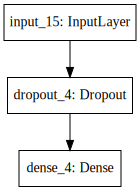

In [57]:
# 可视化模型
keras.utils.plot_model(final_model_obj, to_file='model.png')

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(final_model_obj).create(prog='dot', format='svg'))

In [58]:
# 训练最终模型
def train_final_model(final_model):

    # 模型保存位置
    logs_file = 'ft_extract_features-{val_loss:.4f}.h5'
    path = os.getcwd()
    path_logs = os.path.join(path, logs_file)

    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
    model_check = keras.callbacks.ModelCheckpoint(path_logs, monitor='val_loss', save_best_only=True)

    final_model.fit(x_ft_train, y_ft_train, batch_size=32, epochs=10, 
               validation_data=(x_ft_valid, y_ft_valid), callbacks=[early_stop, model_check])

# 训练
train_final_model(final_model_obj)

Train on 15868 samples, validate on 3968 samples
Epoch 1/10
15868/15868 [==============================] - 24s 2ms/step - loss: 0.0402 - acc: 0.9888 - val_loss: 0.0273 - val_acc: 0.9902
Epoch 2/10
15868/15868 [==============================] - 4s 280us/step - loss: 0.0162 - acc: 0.9953 - val_loss: 0.0186 - val_acc: 0.9942
Epoch 3/10
15868/15868 [==============================] - 4s 267us/step - loss: 0.0139 - acc: 0.9956 - val_loss: 0.0212 - val_acc: 0.9934
Epoch 4/10
15868/15868 [==============================] - 4s 261us/step - loss: 0.0122 - acc: 0.9961 - val_loss: 0.0181 - val_acc: 0.9947
Epoch 5/10
15868/15868 [==============================] - 3s 211us/step - loss: 0.0110 - acc: 0.9970 - val_loss: 0.0215 - val_acc: 0.9937
Epoch 6/10
15868/15868 [==============================] - 3s 220us/step - loss: 0.0105 - acc: 0.9968 - val_loss: 0.0170 - val_acc: 0.9952
Epoch 7/10
15868/15868 [==============================] - 3s 210us/step - loss: 0.0095 - acc: 0.9975 - val_loss: 0.0185 - va

In [60]:
# 预测输出
final_predict = final_model_obj.predict(test_data_feature)
final_predict = final_predict.clip(min=0.005, max=0.995)
final_predict = final_predict.flatten(order = 'F')

# 保存结果
submission = pd.DataFrame(data = {'id':(np.arange(len(test_data))+1), 'label': final_predict})
submission.to_csv('final_submission.csv',index=False)

## 对数损失曲线
绘制模型的对数损失曲线，直观展示

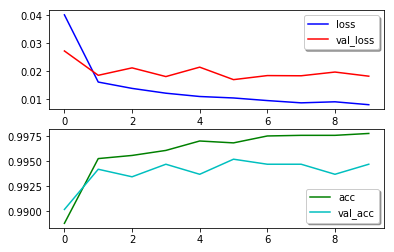

In [64]:
import matplotlib.pyplot as plt

# 对数损失更新曲线
def show_loss(final_model):
    fig, ax = plt.subplots(2,1)
    his_model = final_model.history
    history = his_model.history
    ax[0].plot(history['loss'], color='b', label="loss")
    ax[0].plot(history['val_loss'], color='r', label="val_loss",axes =ax[0])
    legend = ax[0].legend(loc='best', shadow=True)

    ax[1].plot(history['acc'], color='g', label="acc")
    ax[1].plot(history['val_acc'], color='c',label="val_acc")
    legend = ax[1].legend(loc='best', shadow=True)

# 绘制
show_loss(final_model_obj)

## 总结